# Random Forest (Ensemble Model)

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

### (Part0) Data Preparation & Helper Function

We will use Apple Stock Price data from 2021-12-29 to 2021-4-28 (4month). We will include all the technical features we produced to perform feature selection. 

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', start_date = '2021-12-29', sentiment = False):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index=df['Date']
    data = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if sentiment:
        df.index = np.array(range(len(df)))
        df_sentiment = pd.read_csv('data/AAPL_byday_RoBERTa.csv')
        df_sentiment.date = df_sentiment.date.apply(convert)
        df_sentiment.rename(columns={'date':'Date'}, inplace=True)
        df=df.merge(df_sentiment, how='left', on='Date').fillna(0)

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)

    cols = X.columns
    
    X = np.array(X)
    X = X.astype(np.float32)

    # Split training and validation data
    split = int(0.8 * len(X))
    X_train = X[:split]
    y_train = y[:split]

    return X_train, y_train, cols

In [3]:
def convert(date_string):
    year, month, day = [int(i) for i in date_string.split('-')]
    return datetime(year=year, month=month, day=day)

**Helper Function for Feature Importance Evaluation**

In [4]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    Run random forest and return model and accuracy score. 
    '''
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [5]:
def adaboost(X_train, X_test, y_train, y_test):
    '''
    Run adaboost and return model and accuracy score. 
    '''   
    model = AdaBoostClassifier(random_state=42, n_estimators=100, algorithm='SAMME')
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [6]:
def gradient_boost(X_train, X_test, y_train, y_test):
    '''
    Run gradient boosting and return model and accuracy score. 
    '''       
    model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate = 0.001, max_depth = 3, loss = 'exponential')
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [7]:
def cross_validation(df_X, df_y, len_train, num_step, verbose=True):
    '''
    Implement cross validation of each model by sliding window method. 

    df_X, df_y (np): train dataset
    len_train (int): size of window
    num_step (int): size of steps
    verbose (boolean): if True print the outputs
    '''
    
    rf_results = []
    ada_results = []
    gradient_results = []
    rf_feature_imp = np.zeros(df_X.shape[1])
    ada_feature_imp = np.zeros(df_X.shape[1])
    gra_feature_imp = np.zeros(df_X.shape[1])
    
    i = 0
    while True:
        X = df_X[i * num_step : (i * num_step) + len_train]
        y = df_y[i * num_step : (i * num_step) + len_train]
        i += 1

        if len(X) < len_train:
            break

        split = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
        
        t_scaler = MinMaxScaler()
        X_train = t_scaler.fit_transform(X_train)
        X_test = t_scaler.transform(X_test)

        if len(np.unique(y_train)) == 1:
            continue

        rf, rf_accuracy, rf_imp = random_forest(X_train, X_test, y_train, y_test)
        len(rf_imp)
        rf_results.append(rf_accuracy)
        rf_feature_imp = rf_feature_imp + rf_imp
        ada, ada_accuracy, ada_imp = adaboost(X_train, X_test, y_train, y_test)
        ada_results.append(ada_accuracy)
        ada_feature_imp = ada_feature_imp + ada_imp
        gra, gra_accuracy, gra_imp = gradient_boost(X_train, X_test, y_train, y_test)
        gradient_results.append(gra_accuracy)
        gra_feature_imp = gra_feature_imp + gra_imp

    rf_feature_imp = rf_feature_imp / i
    ada_feature_imp = ada_feature_imp / i
    gra_feature_imp = gra_feature_imp / i

    if verbose:
        print("Mean Accuracy of Random Forests", sum(rf_results)/len(rf_results))
        print("Mean Accuracy of Adaboost", sum(ada_results)/len(ada_results))
        print("Mean Accuracy of Gradient Boosting", sum(gradient_results)/len(gradient_results))

    return rf_feature_imp, ada_feature_imp, gra_feature_imp

In [8]:
def feature_importance(importances, columns): 
    feature_names = [i for i in columns]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)
    
    print('Top 20 Best Features : \n')
    print(forest_importances.head(20))
    fig, ax = plt.subplots(figsize=(30,20))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

## Apple

In [9]:
# AAPL : Data with full set of technical features
X_train_AAPL, y_train_AAPL, columns_AAPL = prepare_dataset()

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [10]:
rf_AAPL, ada_AAPL, gra_AAPL = cross_validation(X_train_AAPL, y_train_AAPL, 14, 1)

Mean Accuracy of Random Forests 0.5471698113207549
Mean Accuracy of Adaboost 0.5031446540880504
Mean Accuracy of Gradient Boosting 0.559748427672956


Top 20 Best Features : 

volume_mfi               0.024327
trend_dpo                0.022153
momentum_pvo             0.020911
volatility_bbl           0.020477
trend_ema_slow           0.019322
momentum_ppo_signal      0.018701
trend_vortex_ind_diff    0.018519
momentum_stoch_rsi_k     0.018518
volatility_bbm           0.018417
volatility_kch           0.017661
momentum_pvo_hist        0.017531
Low                      0.017245
volatility_atr           0.017068
momentum_ppo             0.017022
trend_ichimoku_a         0.017011
High                     0.016833
volatility_ui            0.016383
volume_nvi               0.016302
volatility_bbp           0.016043
trend_adx_pos            0.015522
dtype: float64


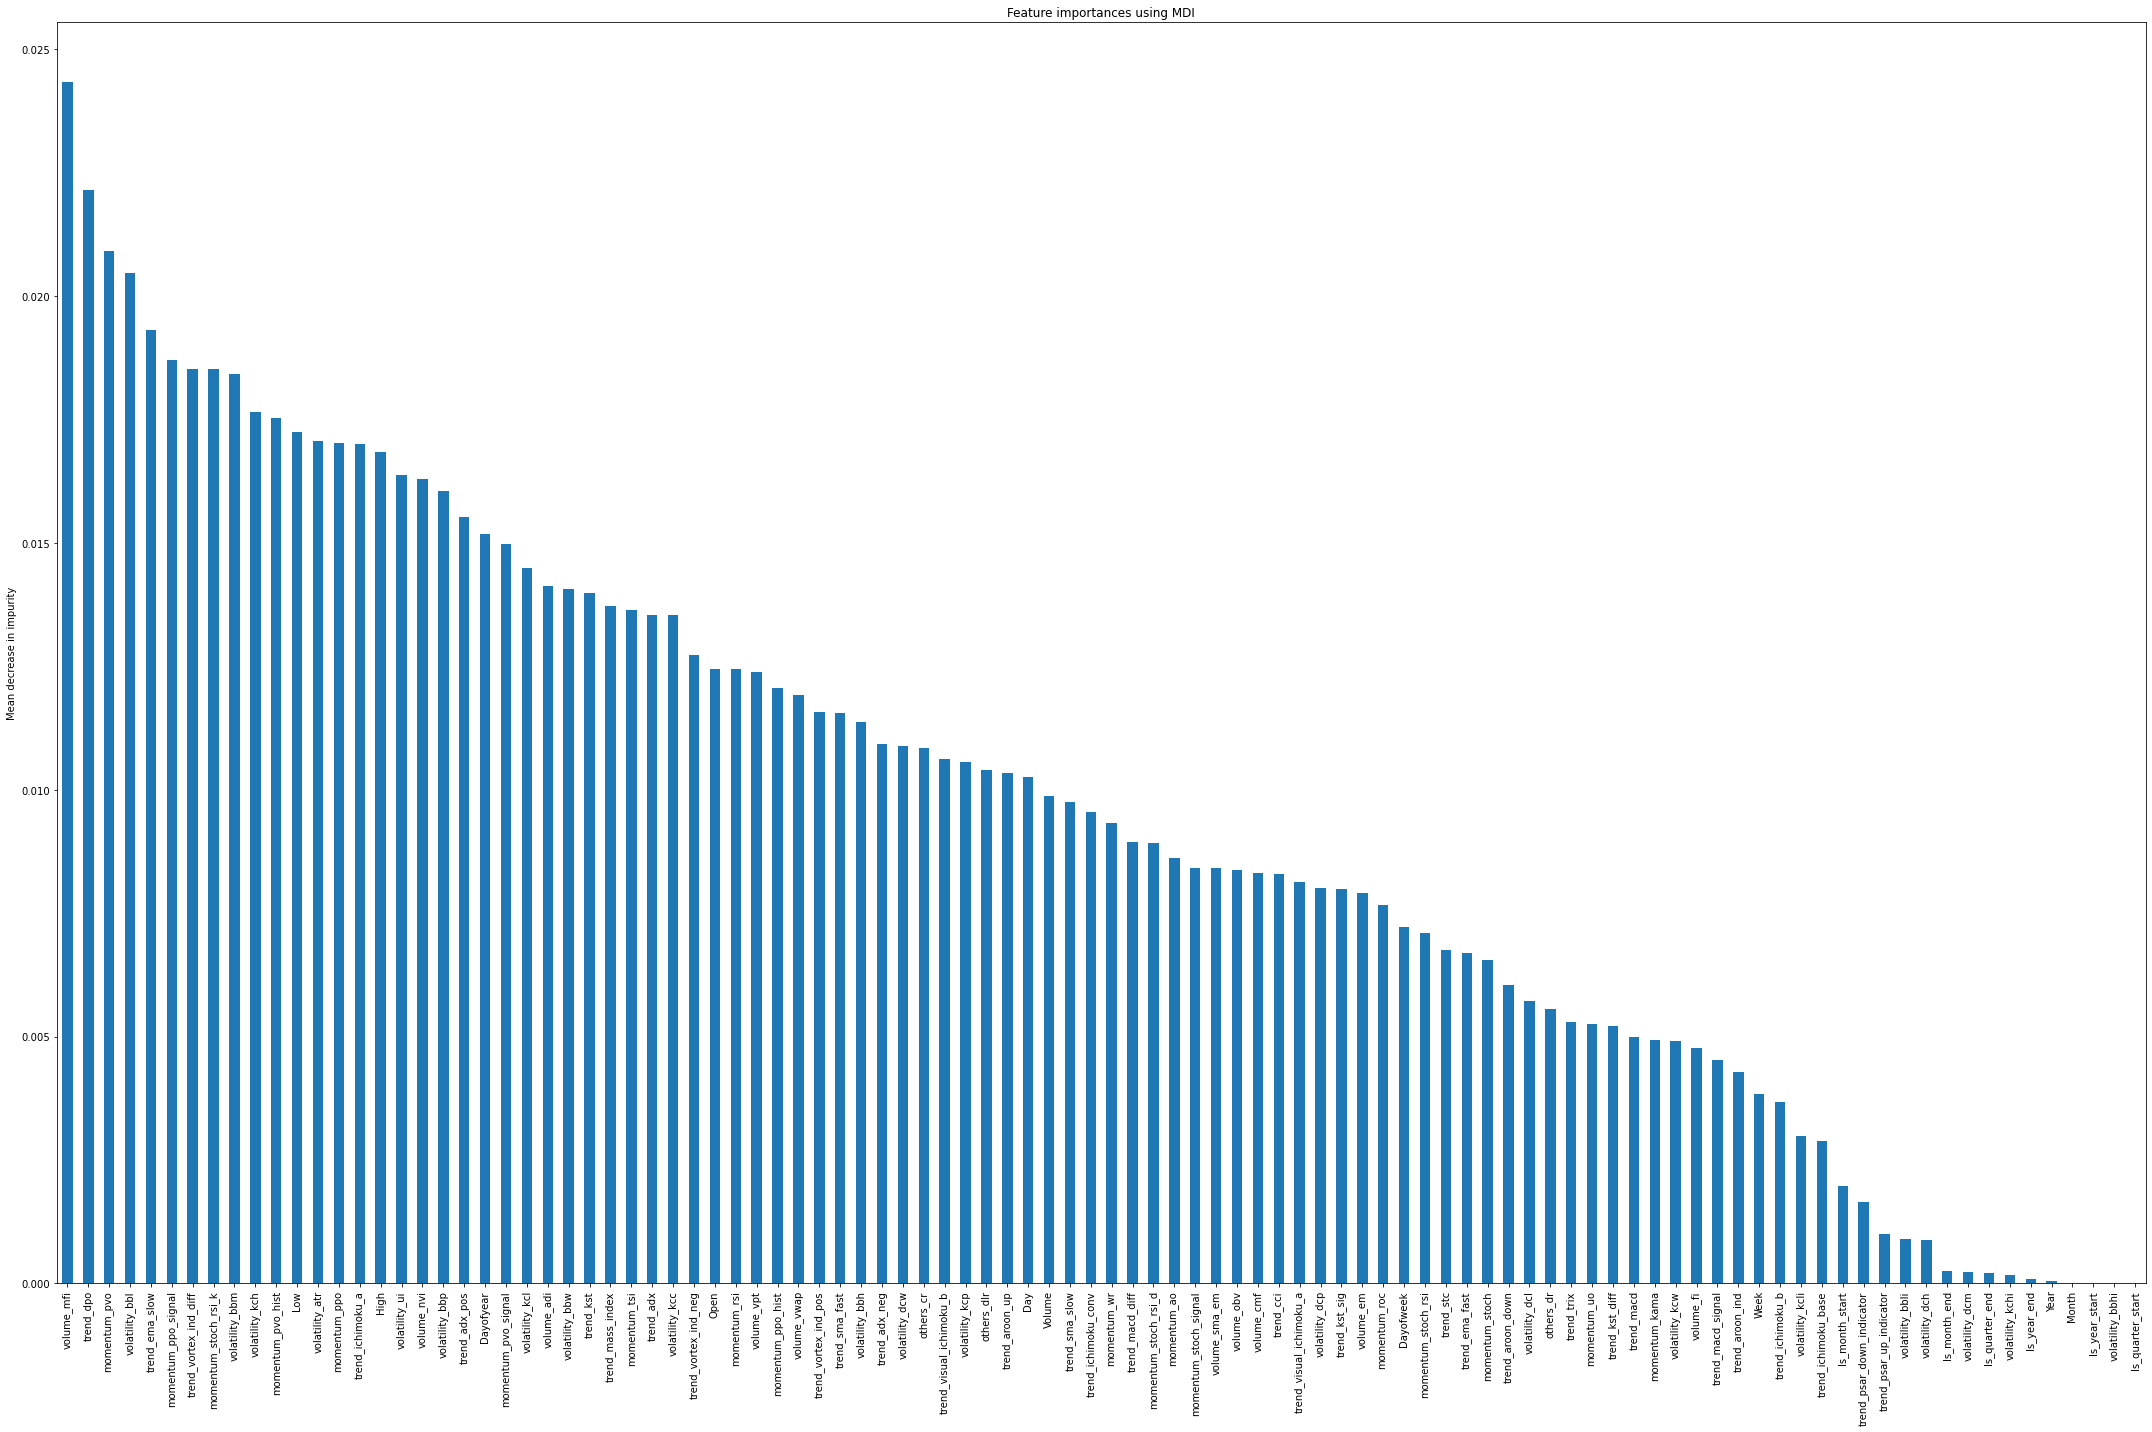

In [11]:
_ = feature_importance(rf_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.068744
volatility_bbp           0.063301
momentum_pvo             0.056077
Week                     0.055034
Open                     0.045291
volatility_kcw           0.037804
volatility_atr           0.037310
volume_obv               0.030536
volume_nvi               0.029739
volume_mfi               0.027466
volatility_bbh           0.022893
trend_ichimoku_conv      0.020913
momentum_stoch_signal    0.020180
trend_adx_pos            0.019219
momentum_kama            0.019095
momentum_stoch_rsi_k     0.018857
volume_vpt               0.016252
trend_sma_slow           0.016178
momentum_pvo_hist        0.015329
trend_mass_index         0.014123
dtype: float64


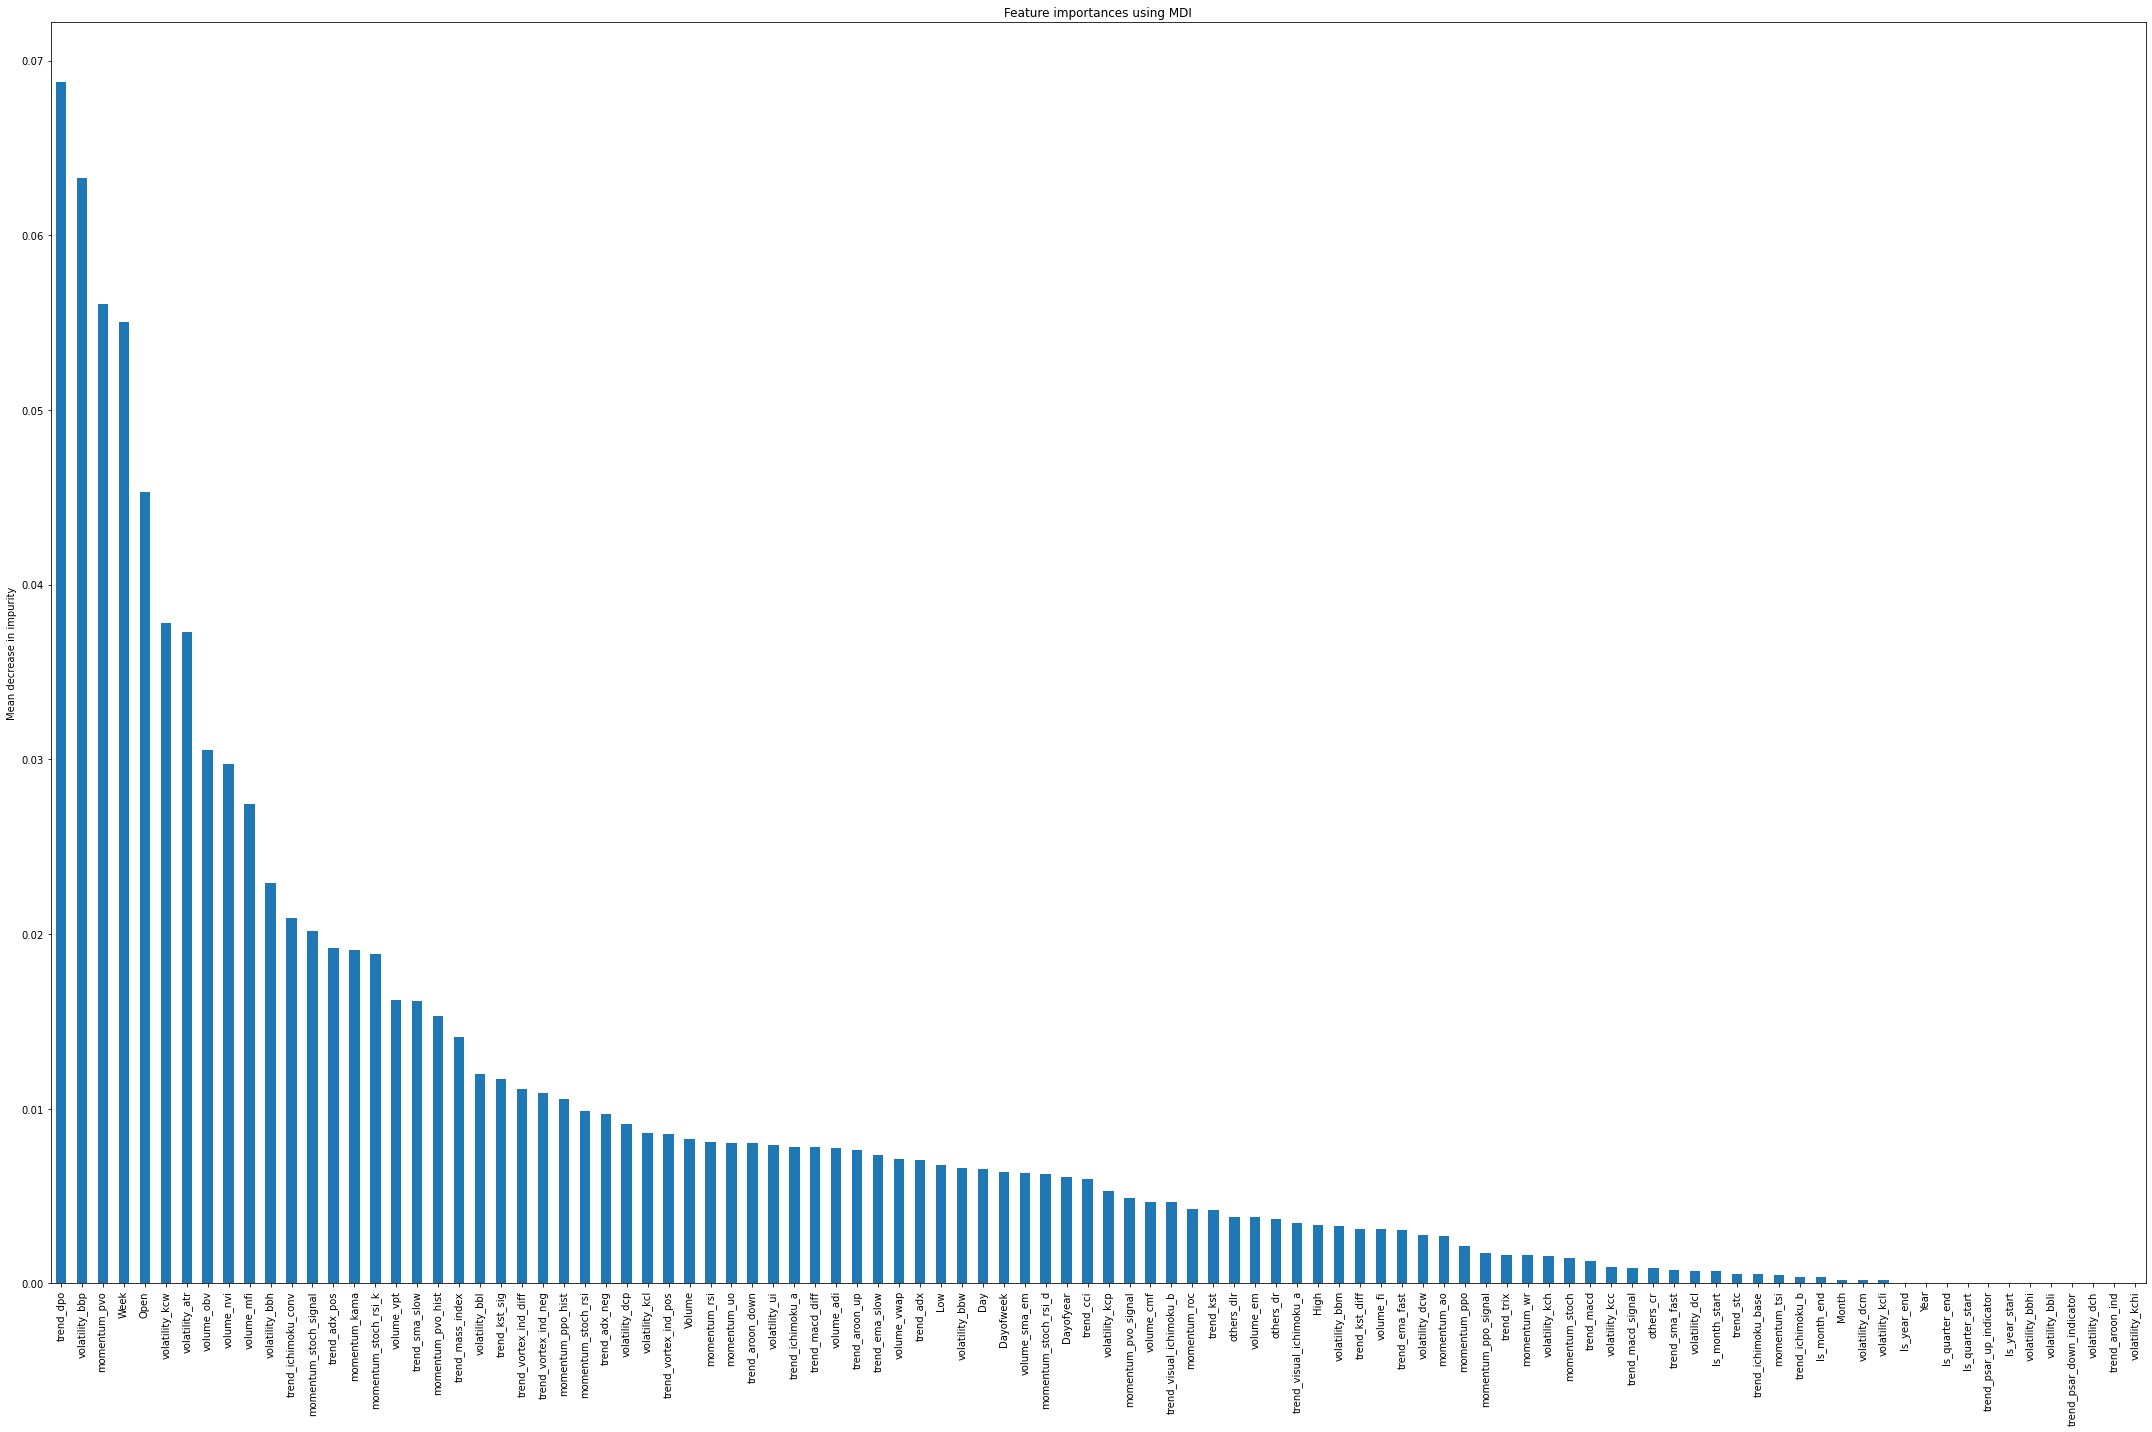

In [12]:
_ = feature_importance(ada_AAPL, columns_AAPL)

Top 20 Best Features : 

momentum_pvo             0.066520
momentum_stoch_signal    0.055141
momentum_pvo_hist        0.037935
Low                      0.036288
volatility_bbp           0.035476
trend_dpo                0.034438
Open                     0.032668
volume_mfi               0.028864
volatility_atr           0.026705
trend_mass_index         0.026702
trend_ichimoku_a         0.020986
trend_adx_pos            0.020125
trend_macd_diff          0.019778
trend_vortex_ind_neg     0.017022
trend_ichimoku_conv      0.016383
momentum_ppo_hist        0.016173
trend_sma_slow           0.015158
volume_vwap              0.014847
volume_adi               0.014131
volume_nvi               0.012358
dtype: float64


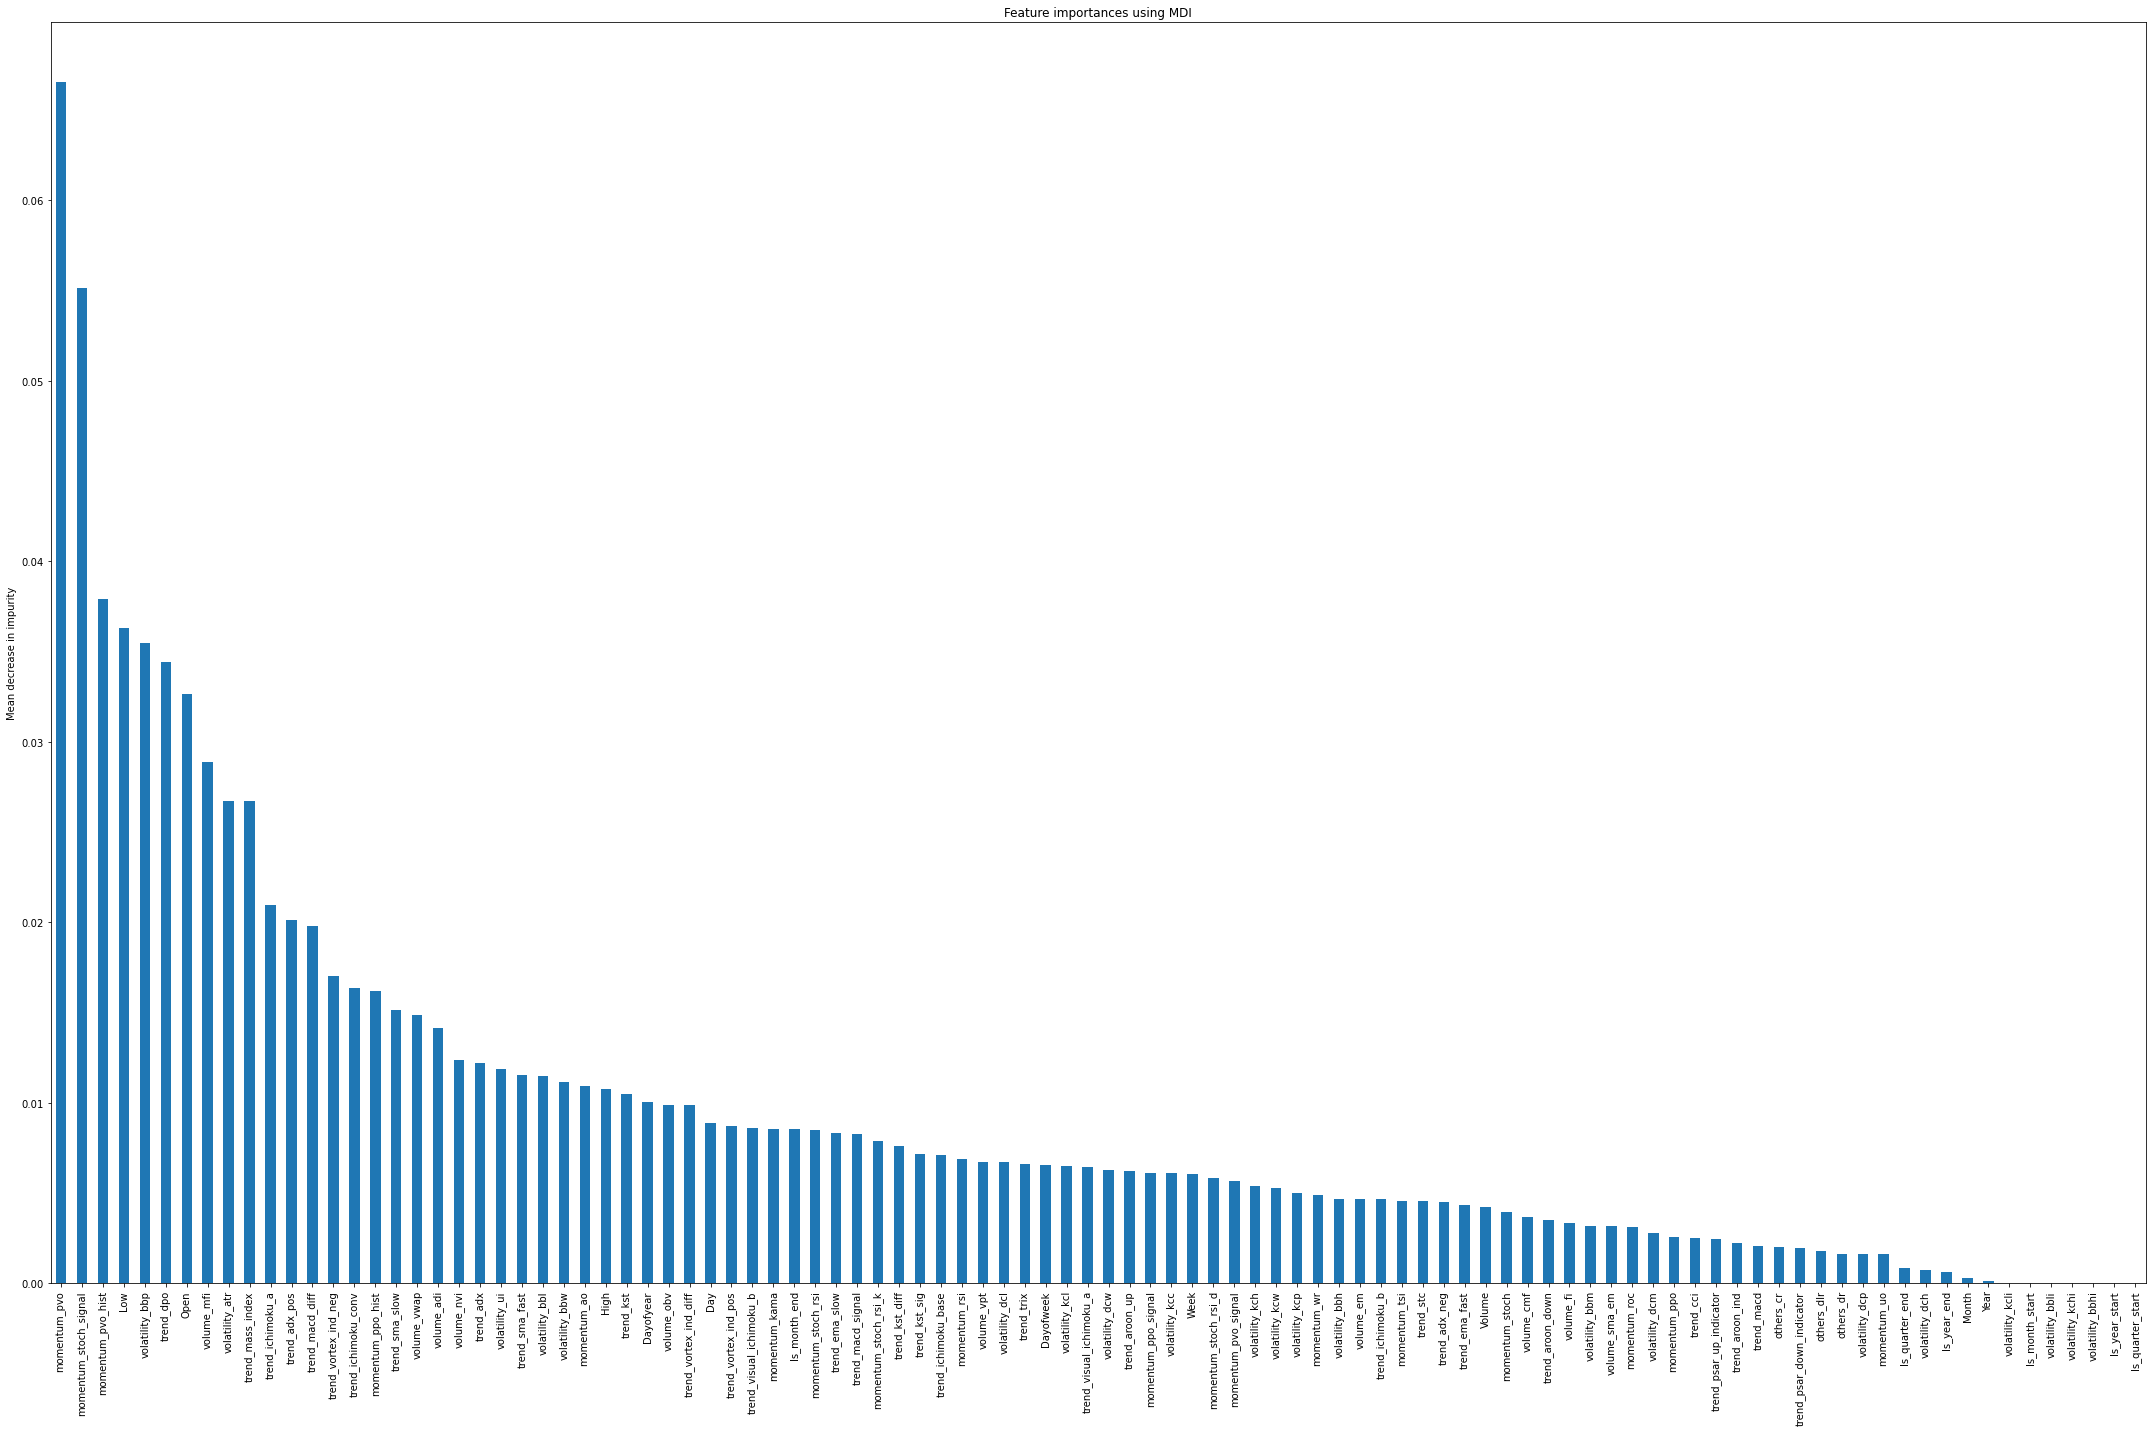

In [13]:
_ = feature_importance(gra_AAPL, columns_AAPL)

Top 20 Best Features : 

momentum_pvo             0.047836
trend_dpo                0.041778
volatility_bbp           0.038273
Open                     0.030135
momentum_stoch_signal    0.027914
volatility_atr           0.027028
volume_mfi               0.026886
momentum_pvo_hist        0.023598
Week                     0.021646
Low                      0.020109
volume_nvi               0.019466
trend_adx_pos            0.018289
trend_mass_index         0.018185
volume_obv               0.016270
volatility_kcw           0.015991
trend_ichimoku_conv      0.015614
trend_ichimoku_a         0.015276
momentum_stoch_rsi_k     0.015081
volatility_bbl           0.014652
trend_sma_slow           0.013698
dtype: float64


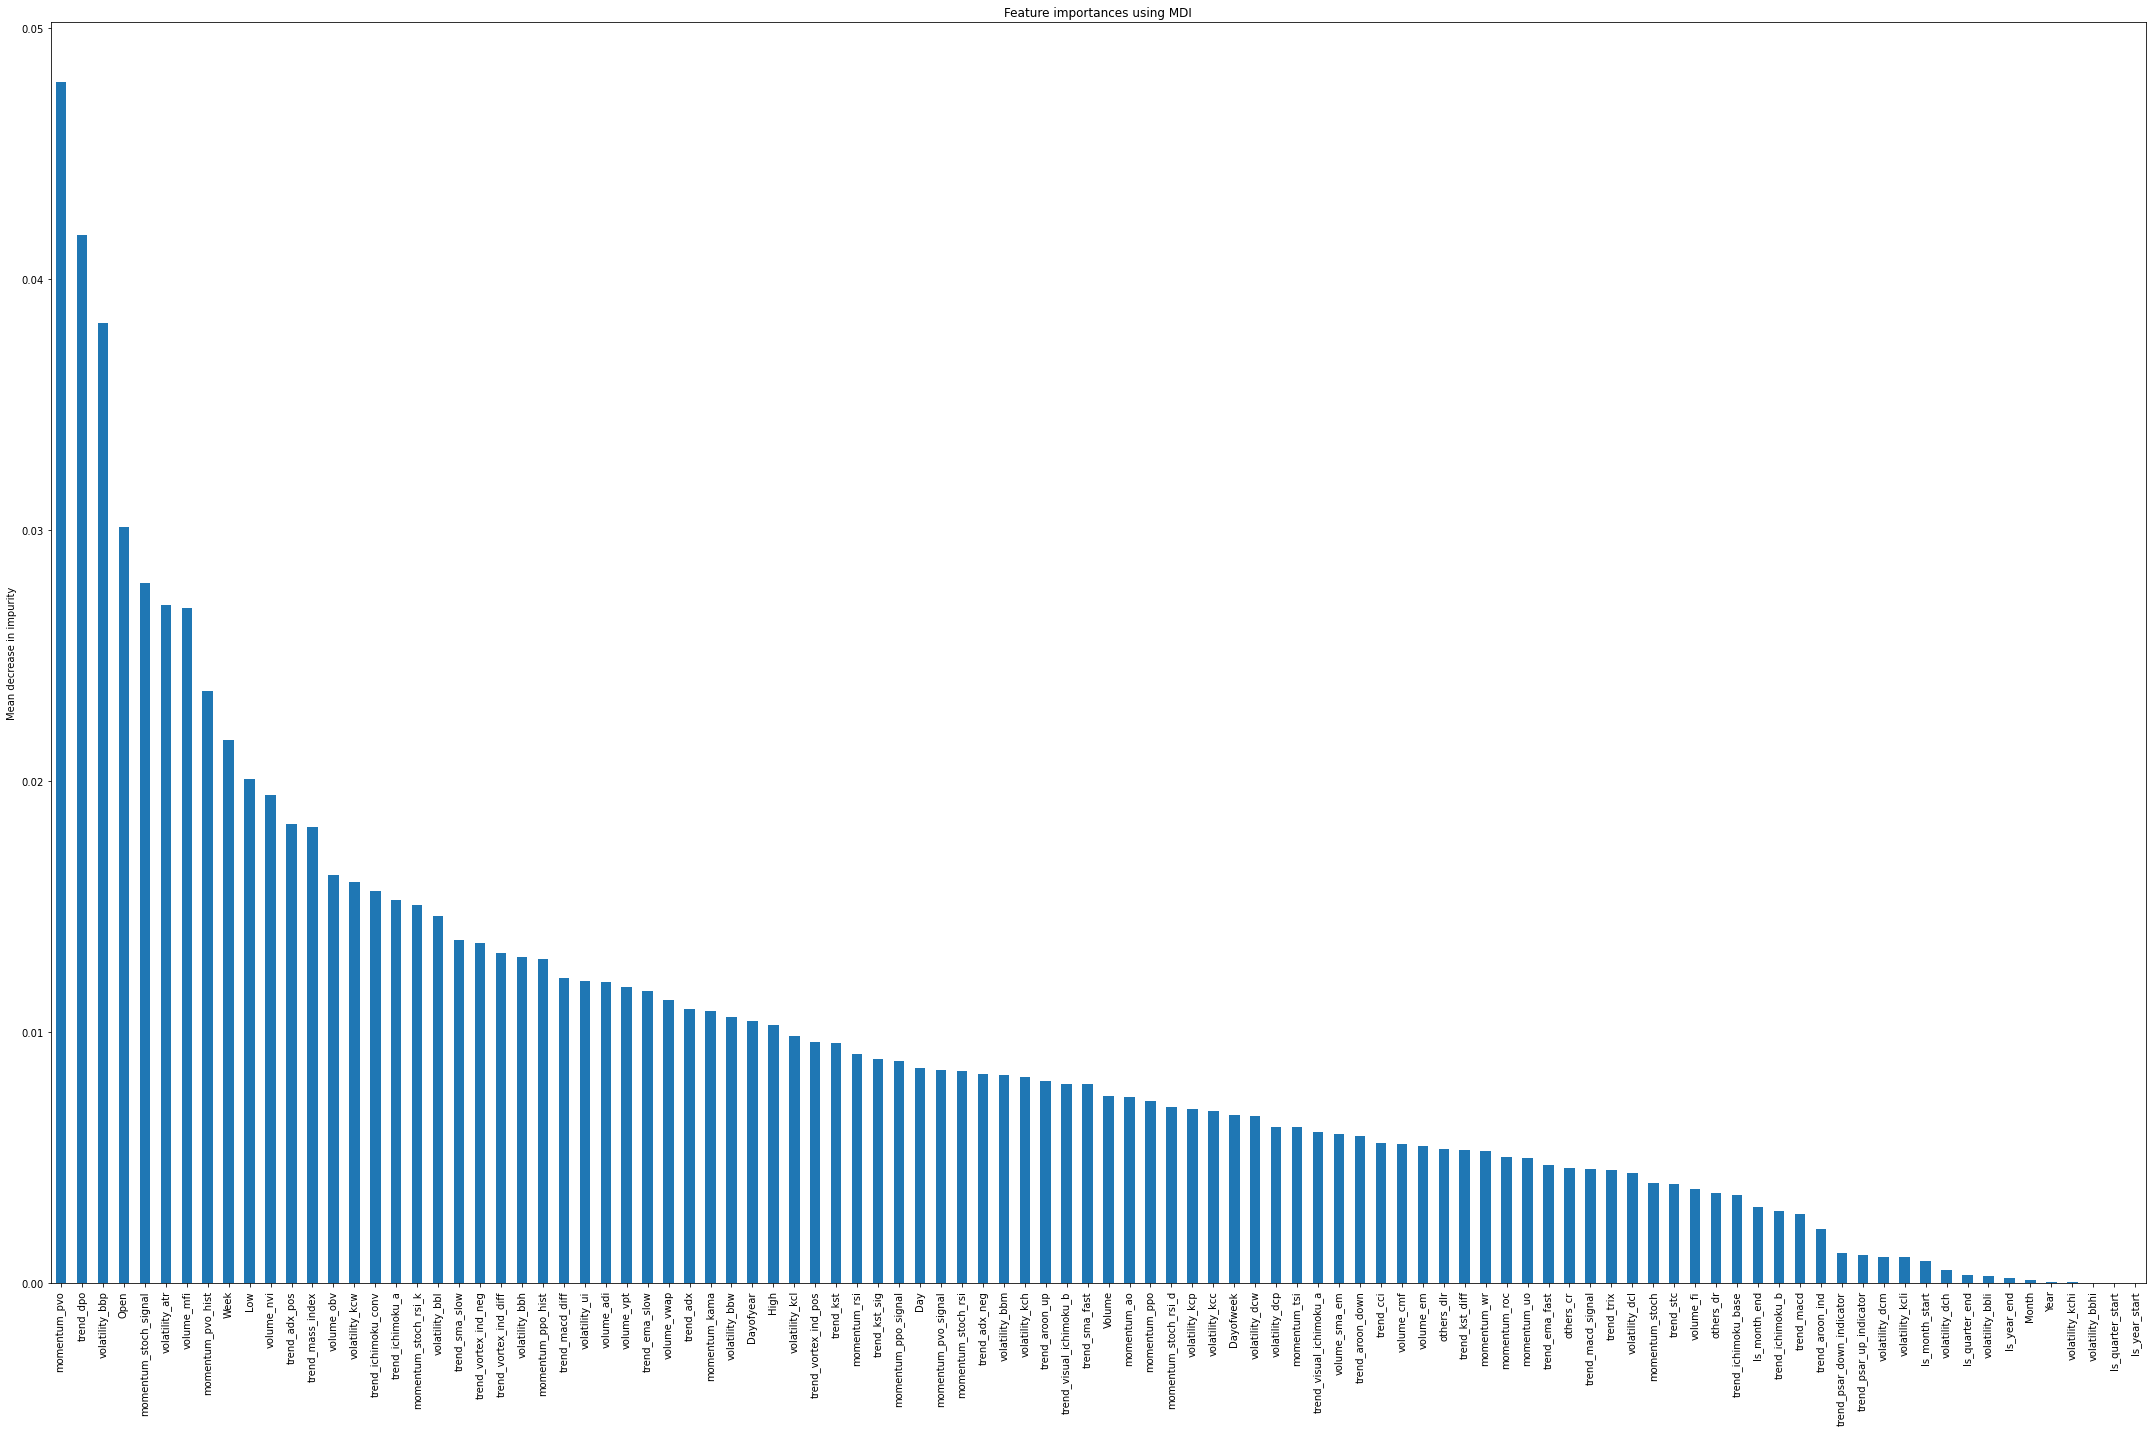

In [14]:
ave_AAPL = (rf_AAPL + ada_AAPL + gra_AAPL) / 3
imp_AAPL = feature_importance(ave_AAPL, columns_AAPL)

## Microsoft

In [15]:
# MSFT : Data with full set of technical features
X_train_MSFT, y_train_MSFT, columns_MSFT = prepare_dataset('data/MSFT_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [16]:
rf_MSFT, ada_MSFT, gra_MSFT = cross_validation(X_train_MSFT, y_train_MSFT, 14, 1)

Mean Accuracy of Random Forests 0.4528301886792453
Mean Accuracy of Adaboost 0.42138364779874216
Mean Accuracy of Gradient Boosting 0.5031446540880503


Top 20 Best Features : 

volume_nvi              0.059857
volatility_kcl          0.046768
volatility_kcp          0.044327
trend_ema_fast          0.036872
momentum_stoch_rsi_k    0.035227
High                    0.031539
volume_mfi              0.027894
momentum_stoch          0.027142
volatility_bbl          0.026361
volatility_bbw          0.025953
Dayofweek               0.025540
trend_adx_pos           0.023725
trend_dpo               0.020859
momentum_rsi            0.020818
momentum_ppo_hist       0.018652
others_cr               0.018434
volume_adi              0.016177
momentum_wr             0.015012
trend_cci               0.014118
volume_obv              0.014045
dtype: float64


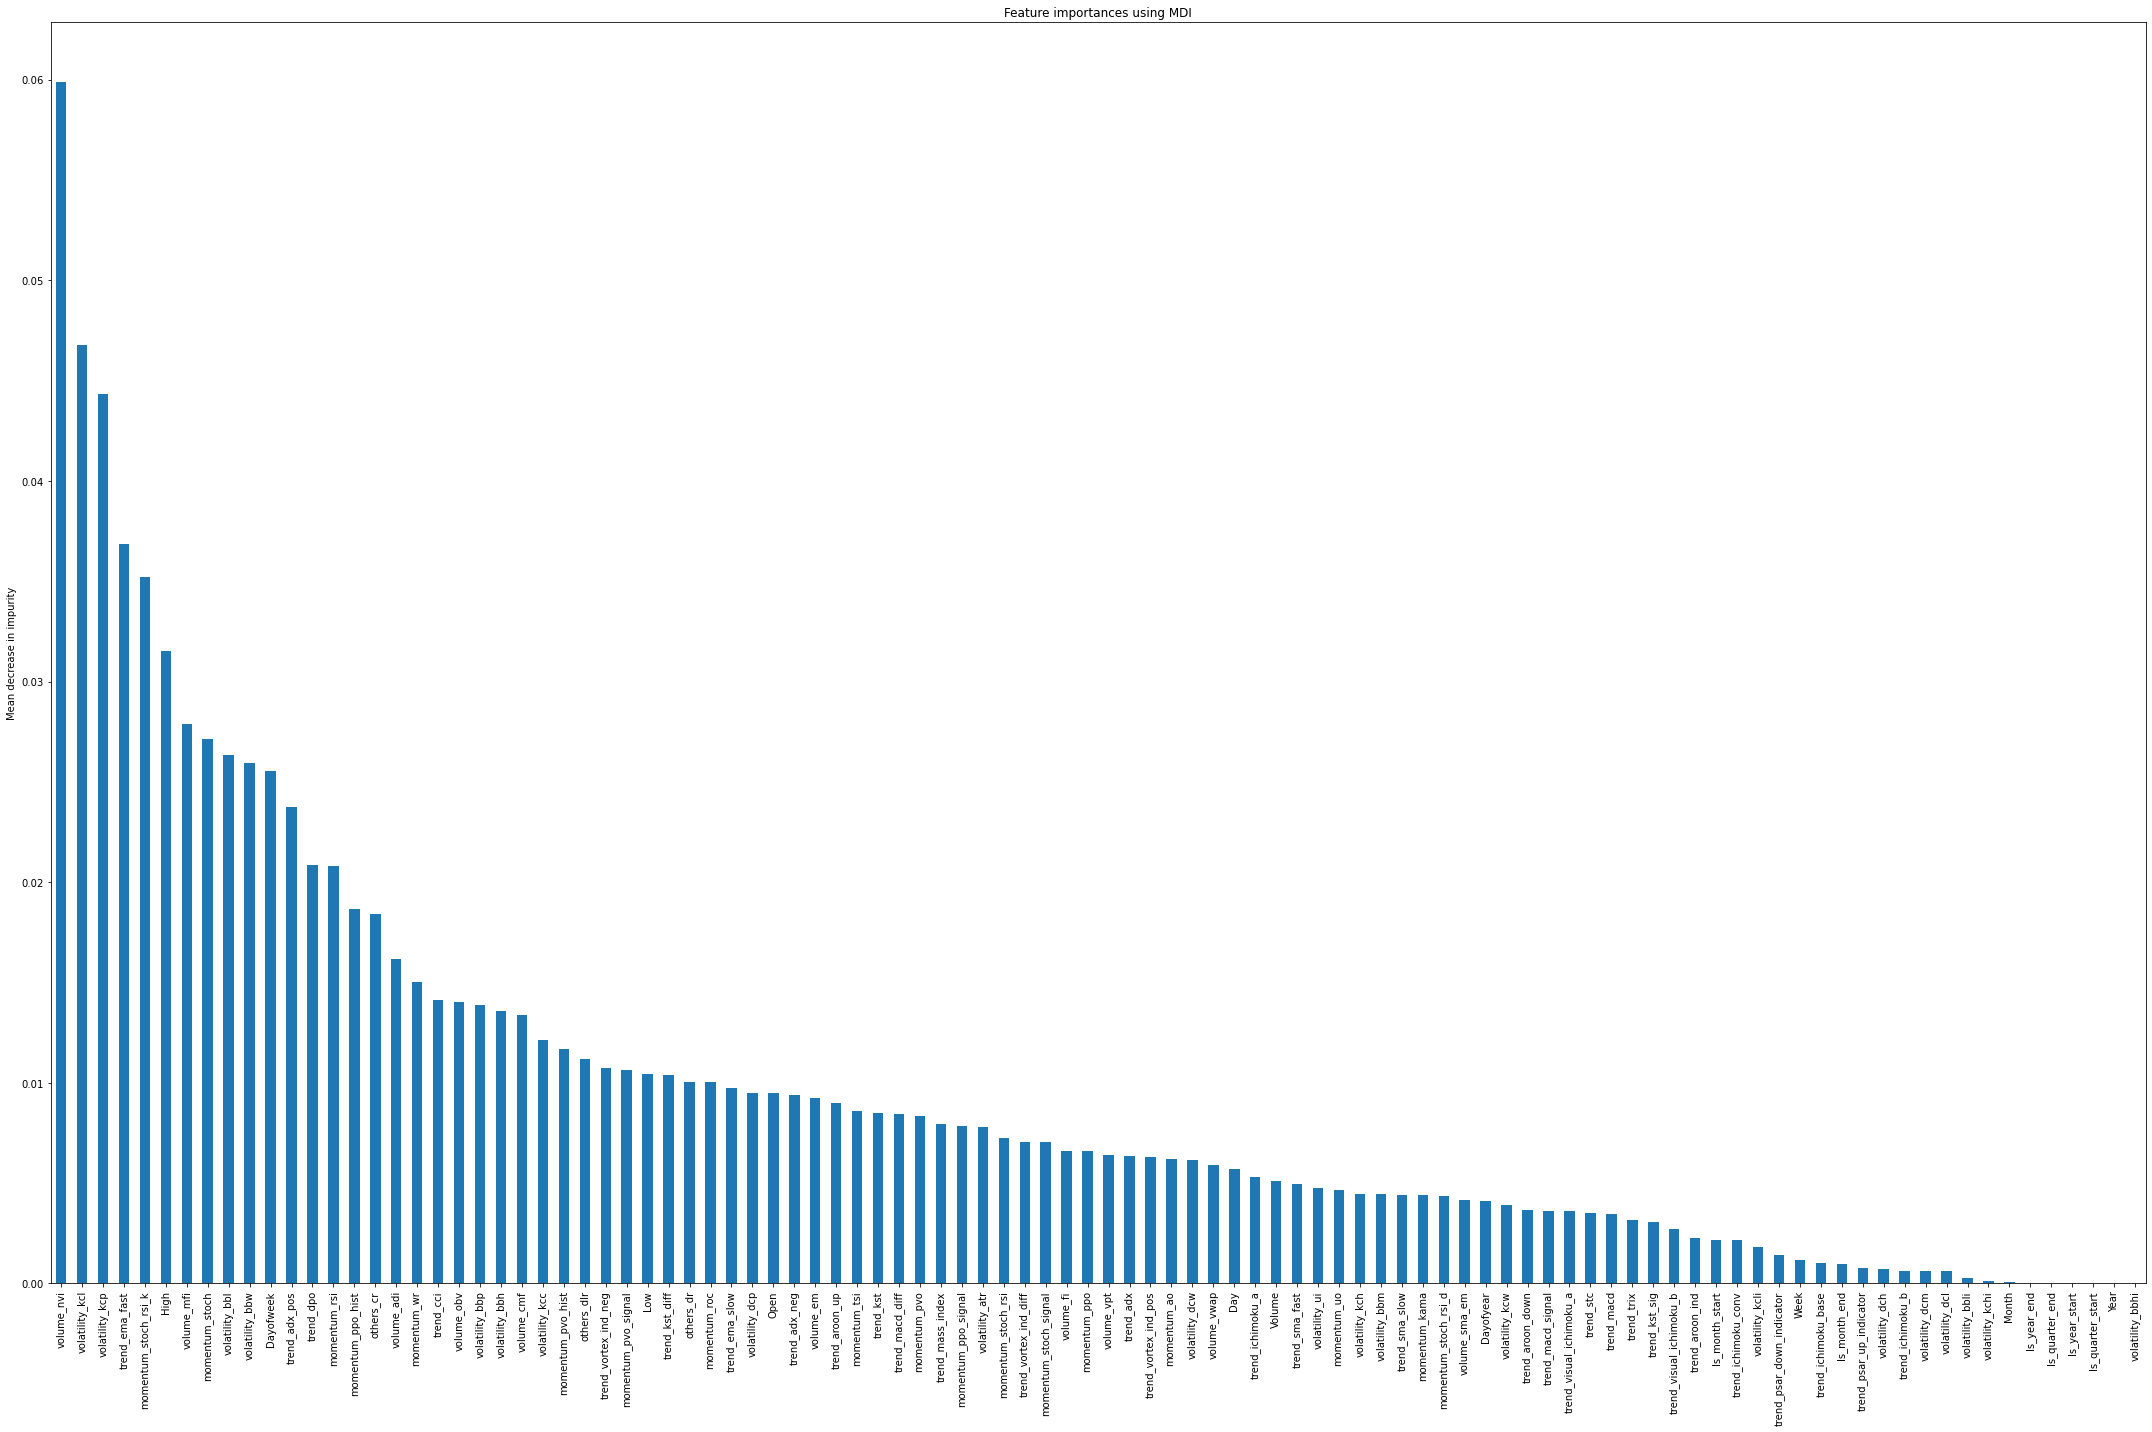

In [17]:
ave_MSFT = (rf_MSFT + ada_MSFT + gra_MSFT) / 3
imp_MSFT = feature_importance(ave_MSFT, columns_MSFT)

## NVDIA

In [18]:
# NVDA : Data with full set of technical features
X_train_NVDA, y_train_NVDA, columns_NVDA = prepare_dataset('data/NVDA_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [19]:
rf_NVDA, ada_NVDA, gra_NVDA = cross_validation(X_train_NVDA, y_train_NVDA, 14, 1)

Mean Accuracy of Random Forests 0.43209876543209863
Mean Accuracy of Adaboost 0.4074074074074072
Mean Accuracy of Gradient Boosting 0.36419753086419737


Top 20 Best Features : 

volatility_kcp          0.036129
volatility_kcl          0.030561
trend_mass_index        0.029920
volume_nvi              0.028547
volatility_atr          0.028503
volume_obv              0.027388
trend_vortex_ind_neg    0.027219
volatility_bbh          0.026616
momentum_stoch_rsi_k    0.025546
momentum_tsi            0.024422
Dayofweek               0.023214
trend_aroon_up          0.022194
trend_ema_fast          0.021245
Volume                  0.021100
volatility_dcw          0.021094
momentum_ppo            0.020726
others_dlr              0.018722
volume_cmf              0.018632
trend_dpo               0.017978
momentum_stoch_rsi_d    0.017372
dtype: float64


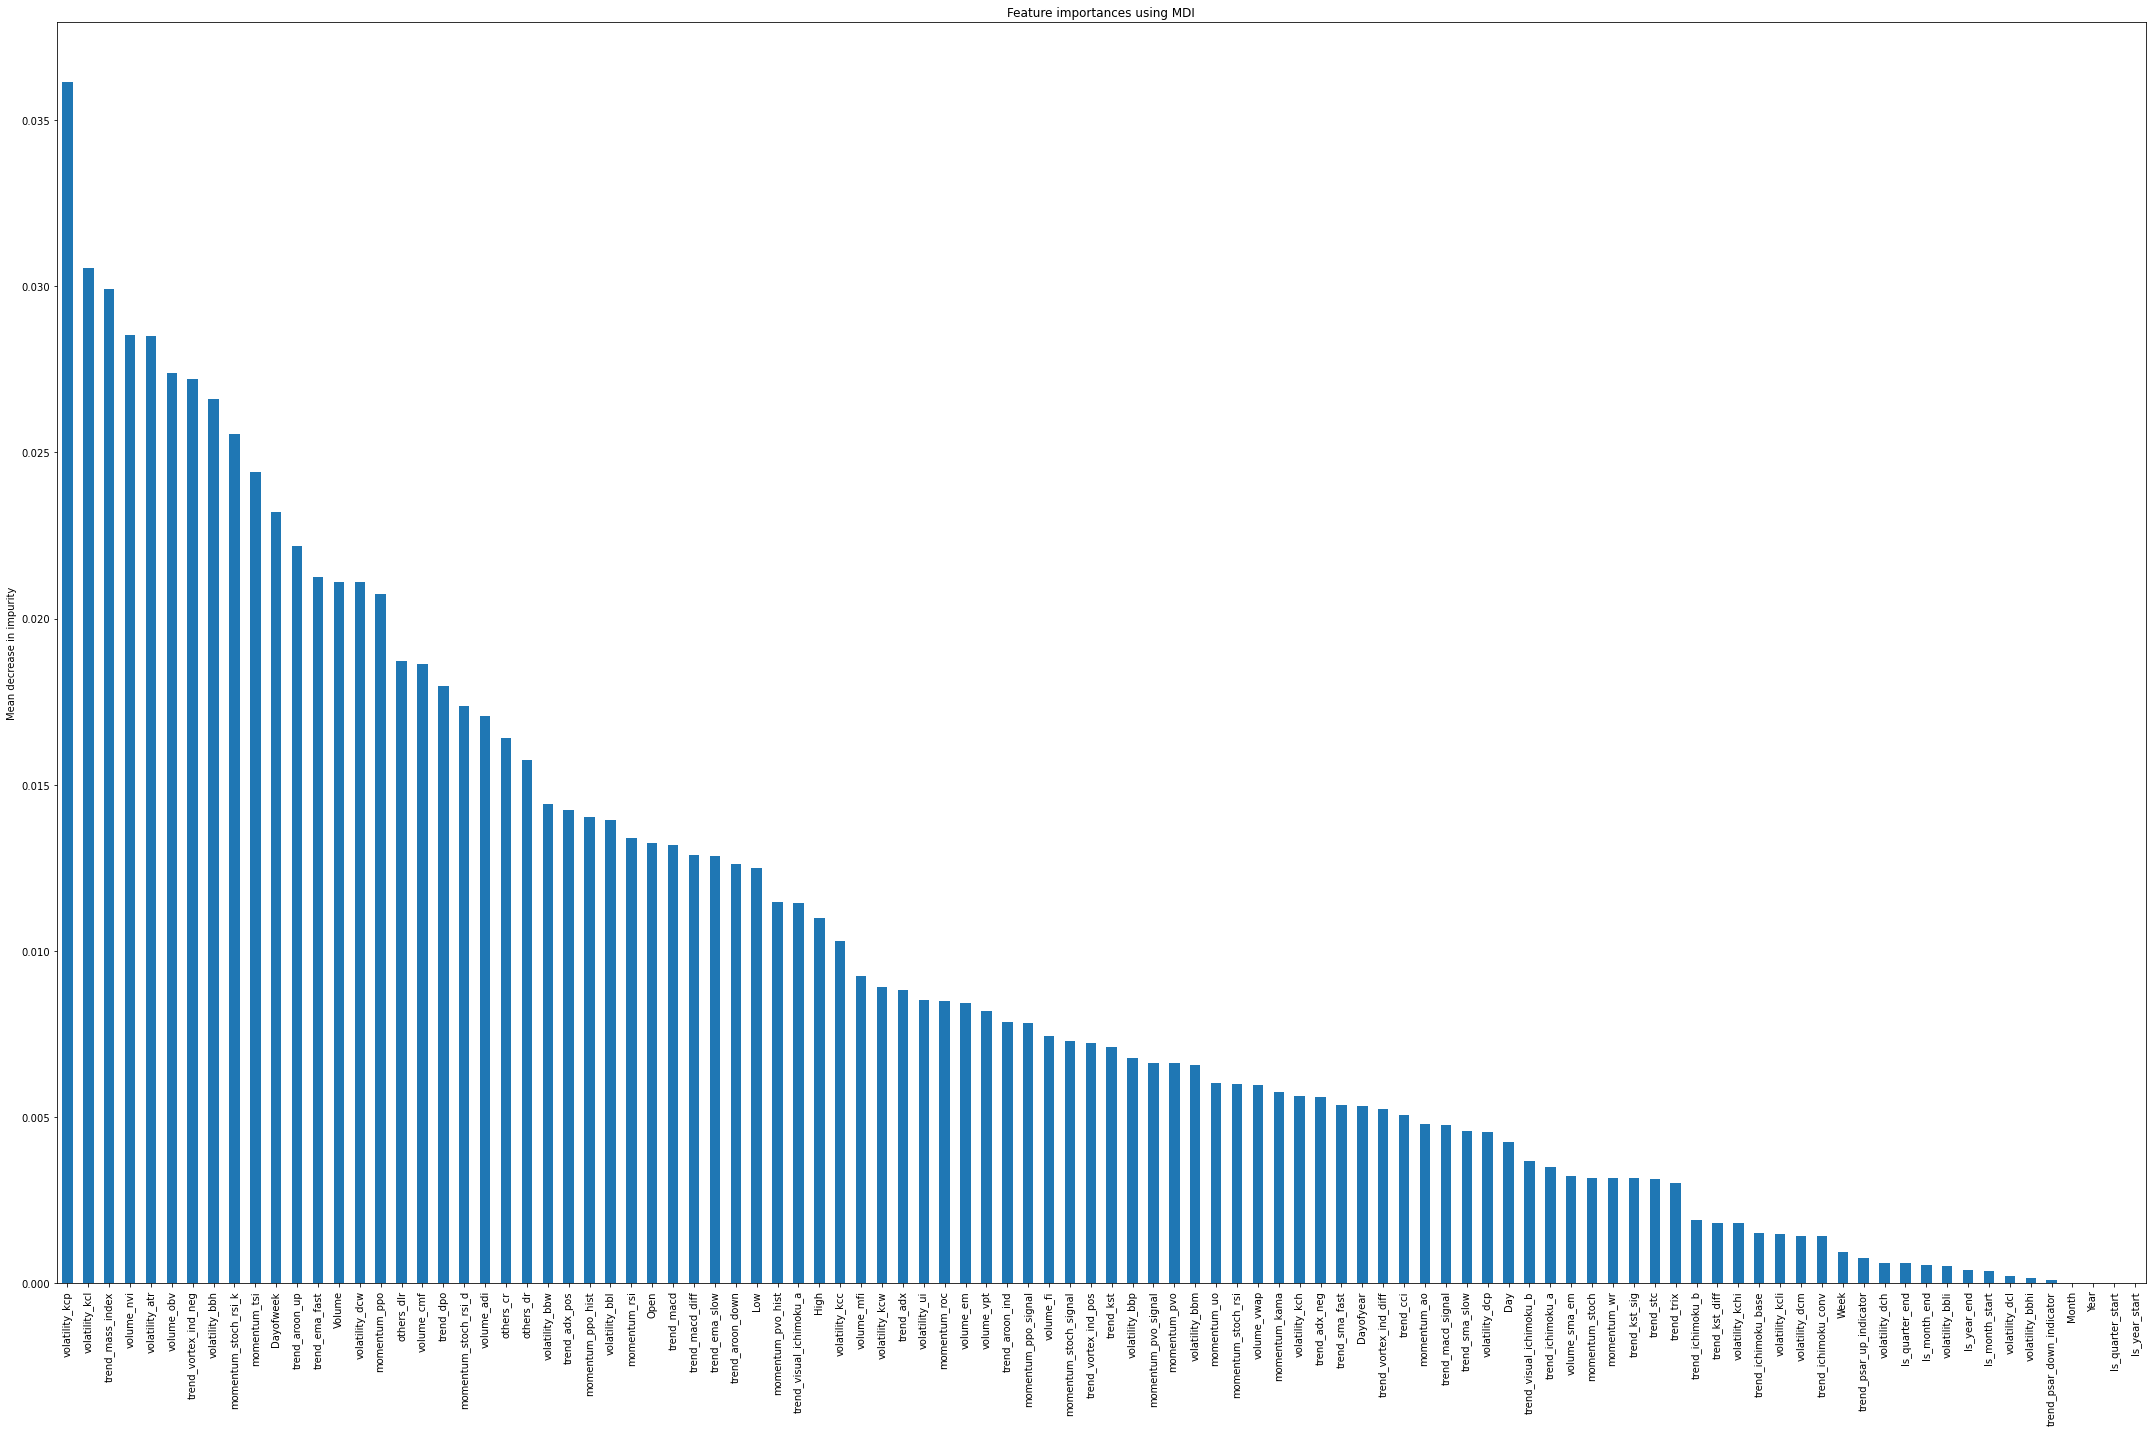

In [20]:
ave_NVDA = (rf_NVDA + ada_NVDA + gra_NVDA) / 3
imp_NVDA = feature_importance(ave_NVDA, columns_NVDA)

## Compare 3 companies feature importance

In [21]:
imp_AAPL.name = "AAPL"
imp_MSFT.name = "MSFT"
imp_NVDA.name = "NVDA"

all_companies = pd.merge(imp_AAPL, imp_MSFT, left_index=True, right_index=True)
all_companies = pd.merge(all_companies, imp_NVDA, left_index=True, right_index=True)

In [22]:
all_companies

,AAPL,MSFT,NVDA
momentum_pvo,0.047836,0.008337,0.006626
trend_dpo,0.041778,0.020859,0.017978
volatility_bbp,0.038273,0.013874,0.006782
Open,0.030135,0.009467,0.013251
momentum_stoch_signal,0.027914,0.007056,0.007301
...,...,...,...
Year,0.000073,0.000000,0.000019
volatility_kchi,0.000059,0.000096,0.001804
volatility_bbhi,0.000000,0.000000,0.000164
Is_quarter_start,0.000000,0.000000,0.000000


<AxesSubplot:>

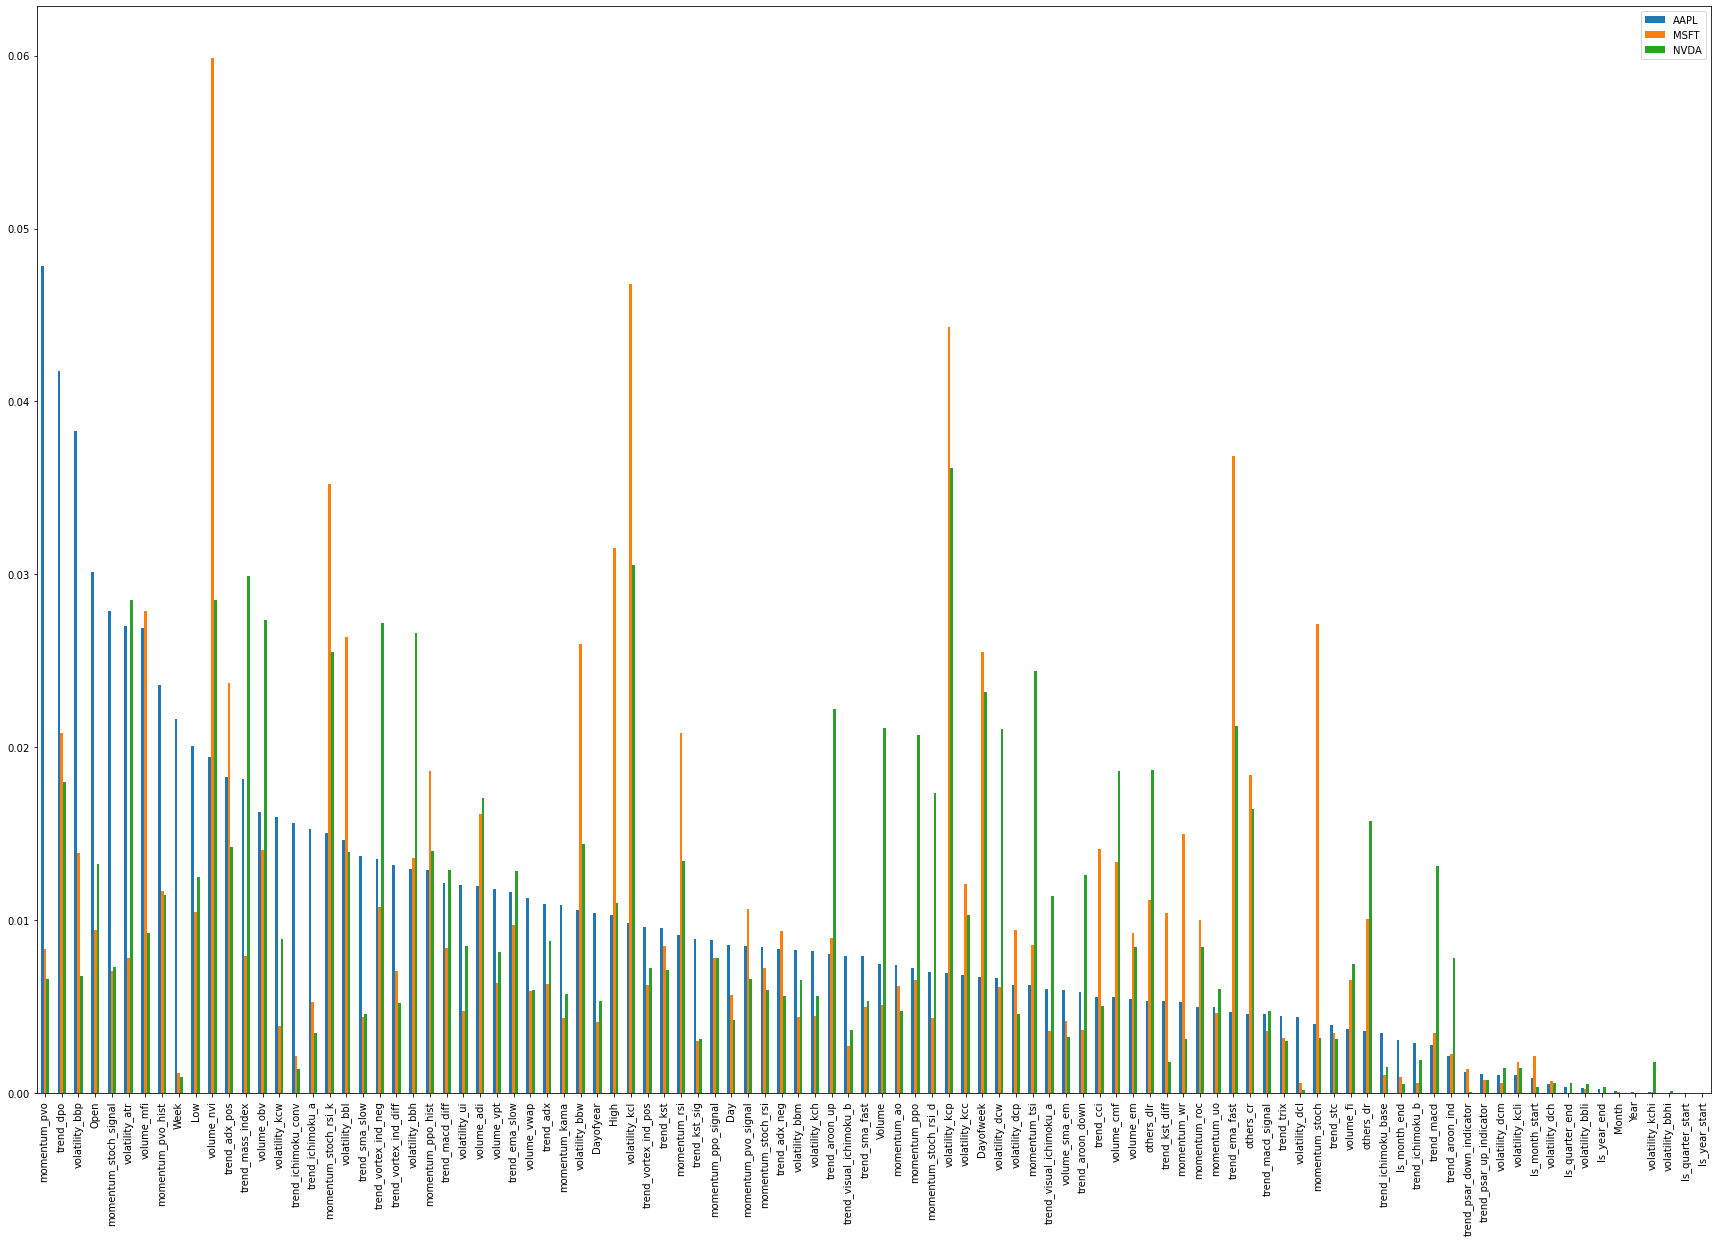

In [23]:
all_companies.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)

## Add Apple RoBERTa

In [24]:
# AAPL : Data with full set of technical features + sentiment score
X_train_AAPLs, y_train_AAPLs, columns_AAPLs = prepare_dataset(sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.5408805031446542
Mean Accuracy of Adaboost 0.5157232704402517
Mean Accuracy of Gradient Boosting 0.5660377358490566
Top 20 Best Features : 

momentum_pvo               0.046229
Low                        0.039559
trend_dpo                  0.037288
Open                       0.031324
volatility_bbl             0.030855
momentum_stoch_signal      0.029575
volume_mfi                 0.028191
volatility_atr             0.027562
trend_visual_ichimoku_a    0.023930
momentum_pvo_hist          0.021543
trend_adx_pos              0.019898
bullish                    0.019704
volume_obv                 0.018249
trend_ichimoku_a           0.018034
volatility_bbp             0.017724
volume_vwap                0.017110
trend_vortex_ind_neg       0.016551
trend_mass_index           0.016311
volume_nvi                 0.015844
trend_macd_diff            0.014778
dtype: float64


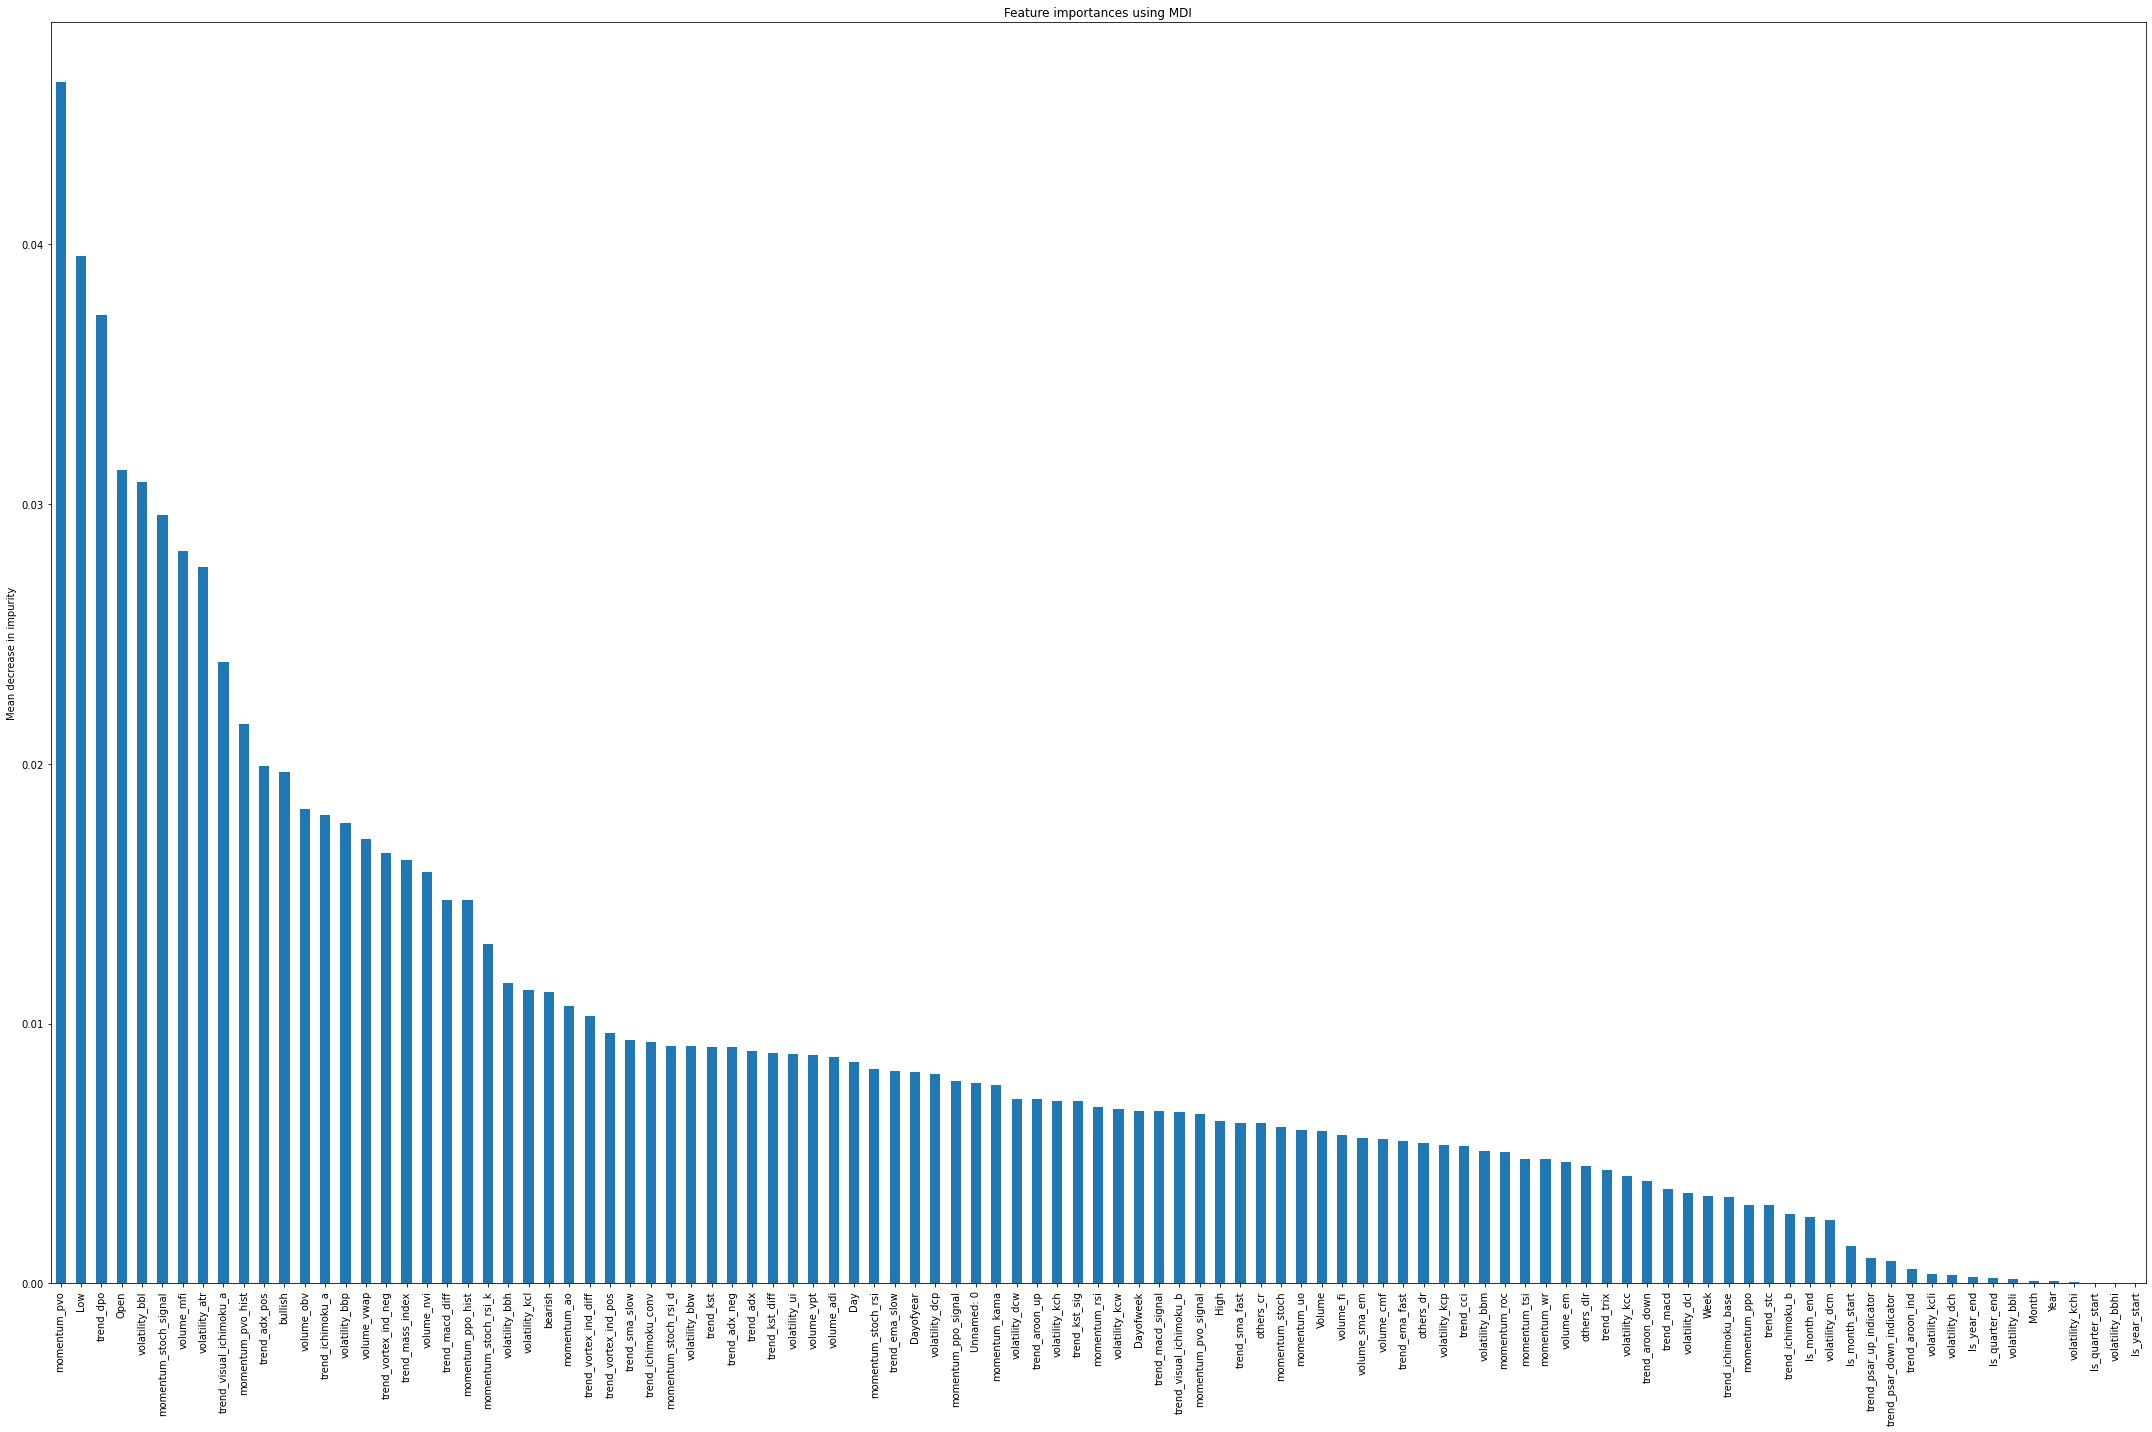

In [25]:
rf_AAPLs, ada_AAPLs, gra_AAPLs = cross_validation(X_train_AAPLs, y_train_AAPLs, 14, 1)
ave_AAPLs = (rf_AAPLs + ada_AAPLs + gra_AAPLs) / 3
_ = feature_importance(ave_AAPLs, columns_AAPLs)